# Actividad 2: Segmentación

Esta práctica está realizada por el grupo numero 6 que está comprendido por los siguientes alumnos:
* Jose Manuel Alcaide Carrera.

## Librerías y funciones dadas 

In [77]:
# Cargar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2gray, label2rgb
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import (active_contour, felzenszwalb, quickshift, 
                                 mark_boundaries, slic, clear_border)

from skimage.future.graph import rag_mean_color, cut_normalized
import io

from skimage import segmentation, color
from skimage.future import graph

from itertools import product

from scipy import ndimage

In [9]:
# Defino una función para mostrar una imagen por pantalla con el criterio que considero más acertado
def imshow(img):
    fig, ax = plt.subplots(figsize=(7, 7))
    # El comando que realmente muestra la imagen
    ax.imshow(img,cmap=plt.cm.gray)
    # Para evitar que aparezcan los números en los ejes
    ax.set_xticks([]), ax.set_yticks([])
    plt.show()

In [10]:
# Función para comparar cómo de buena es una determinada segmentación en comparación con el ground truth
# Ambas imagenes deben contener valores True/False
def factor_f_evaluation(binary_image, ground_truth):
    TP = np.sum(np.logical_and(binary_image, ground_truth))
    TN = np.sum(np.logical_and(np.logical_not(binary_image), np.logical_not(ground_truth)))
    FP = np.sum(np.logical_and(np.logical_not(binary_image), ground_truth))
    FN = np.sum(np.logical_and(binary_image, np.logical_not(ground_truth)))
    P = TP/np.float(TP+FP)
    R = TP/np.float(TP+FN)
    if P+R == 0:
        F = 0
    else:
        F = 2*P*R/(P+R)
    return F

In [11]:
def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
                                     graph.node[dst]['pixel count'])

In [12]:
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}

## Imagen inicial y objetivo

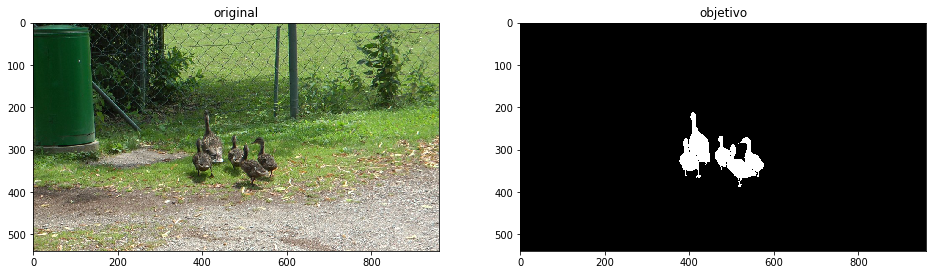

In [311]:
# https://lmb.informatik.uni-freiburg.de/resources/datasets/moseg.en.html
patos = data.imread('img/ducks01_0100.jpg')
gt_patos = rgb2gray(data.imread('img/ducks01_0100_gt.png'))<1

f, ([ax1, ax2]) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(patos)
ax1.set_title("original")
ax2.imshow(gt_patos, cmap='gray')
ax2.set_title("objetivo")
plt.show()

## 1. Suavizado mediante filtro de la mediana

In [114]:
med_denoised_1 = ndimage.median_filter(patos, 1)
med_denoised_2 = ndimage.median_filter(patos, 2)
med_denoised_3 = ndimage.median_filter(patos, 3)
med_denoised_4 = ndimage.median_filter(patos, 4)
med_denoised_5 = ndimage.median_filter(patos, 5)
med_denoised_10 = ndimage.median_filter(patos, 10)
med_denoised_20 = ndimage.median_filter(patos, 20)

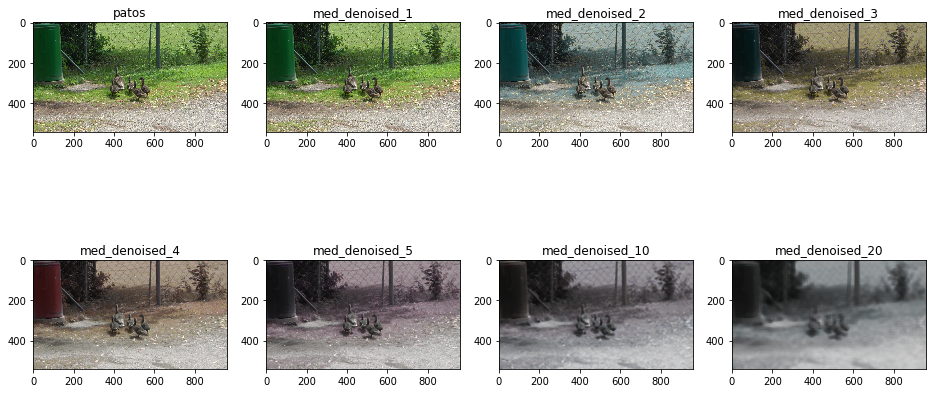

In [115]:
f, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]) = plt.subplots(2, 4, figsize=(16, 8))
ax1.imshow(patos)
ax1.set_title("patos")
ax2.imshow(med_denoised_1)
ax2.set_title("med_denoised_1")
ax3.imshow(med_denoised_2)
ax3.set_title("med_denoised_2")
ax4.imshow(med_denoised_3)
ax4.set_title("med_denoised_3")
ax5.imshow(med_denoised_4)
ax5.set_title("med_denoised_4")
ax6.imshow(med_denoised_5)
ax6.set_title("med_denoised_5")
ax7.imshow(med_denoised_10)
ax7.set_title("med_denoised_10")
ax8.imshow(med_denoised_20)
ax8.set_title("med_denoised_20")
plt.show()

## 2. Conversión a monocanal

In [116]:
bn = patos[:,:,1]
bn1 = med_denoised_1[:,:,1]
bn2 = med_denoised_2[:,:,1]
bn3 = med_denoised_3[:,:,1]
bn4 = med_denoised_4[:,:,1]
bn5 = med_denoised_5[:,:,1]
bn10 = med_denoised_10[:,:,1]
bn20 = med_denoised_20[:,:,1]

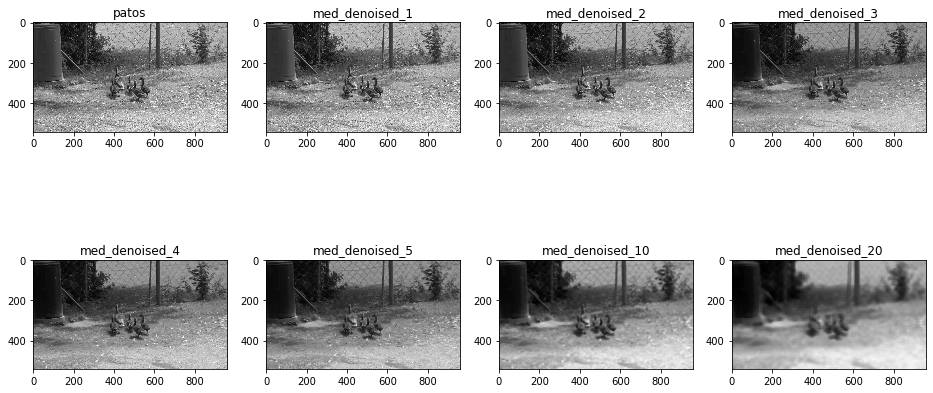

In [119]:
f, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]) = plt.subplots(2, 4, figsize=(16, 8))
ax1.imshow(bn, cmap='gray')
ax1.set_title("patos")
ax2.imshow(bn1, cmap='gray')
ax2.set_title("med_denoised_1")
ax3.imshow(bn2, cmap='gray')
ax3.set_title("med_denoised_2")
ax4.imshow(bn3, cmap='gray')
ax4.set_title("med_denoised_3")
ax5.imshow(bn4, cmap='gray')
ax5.set_title("med_denoised_4")
ax6.imshow(bn5, cmap='gray')
ax6.set_title("med_denoised_5")
ax7.imshow(bn10, cmap='gray')
ax7.set_title("med_denoised_10")
ax8.imshow(bn20, cmap='gray')
ax8.set_title("med_denoised_20")
plt.show()

## 3. Detección de bordes (Sobel, Prewitt, Canny)

### 3.1 Sobel

In [120]:
imsobel = filters.sobel(bn)
imsobel1 = filters.sobel(bn1)
imsobel2 = filters.sobel(bn2)
imsobel3 = filters.sobel(bn3)
imsobel4 = filters.sobel(bn4)
imsobel5 = filters.sobel(bn5)
imsobel10 = filters.sobel(bn10)
imsobel20 = filters.sobel(bn20)

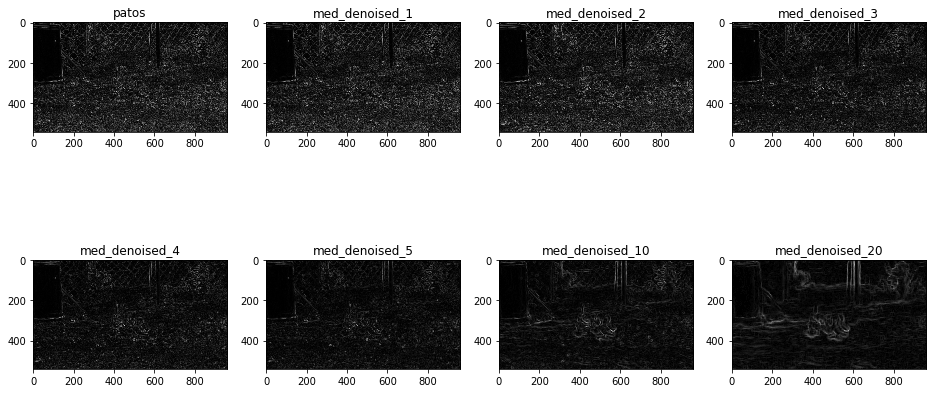

In [121]:
f, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]) = plt.subplots(2, 4, figsize=(16, 8))
ax1.imshow(imsobel, cmap='gray')
ax1.set_title("patos")
ax2.imshow(imsobel1, cmap='gray')
ax2.set_title("med_denoised_1")
ax3.imshow(imsobel2, cmap='gray')
ax3.set_title("med_denoised_2")
ax4.imshow(imsobel3, cmap='gray')
ax4.set_title("med_denoised_3")
ax5.imshow(imsobel4, cmap='gray')
ax5.set_title("med_denoised_4")
ax6.imshow(imsobel5, cmap='gray')
ax6.set_title("med_denoised_5")
ax7.imshow(imsobel10, cmap='gray')
ax7.set_title("med_denoised_10")
ax8.imshow(imsobel20, cmap='gray')
ax8.set_title("med_denoised_20")
plt.show()

**Los mejores resultados con Sobel son los del filtro de mediana de tamaño 10 y 20**

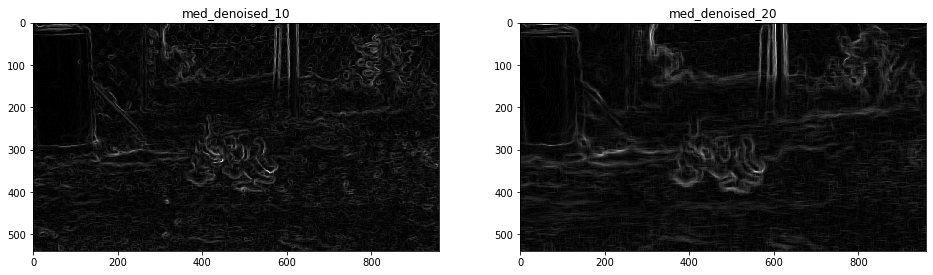

In [122]:
f, ([ax7, ax8]) = plt.subplots(1, 2, figsize=(16, 8))
ax7.imshow(imsobel10, cmap='gray')
ax7.set_title("med_denoised_10")
ax8.imshow(imsobel20, cmap='gray')
ax8.set_title("med_denoised_20")
plt.show()

### 3.2 Prewitt

In [265]:
imprewitt = filters.prewitt(bn)
imprewitt1 = filters.prewitt(bn1)
imprewitt2 = filters.prewitt(bn2)
imprewitt3 = filters.prewitt(bn3)
imprewitt4 = filters.prewitt(bn4)
imprewitt5 = filters.prewitt(bn5)
imprewitt10 = filters.prewitt(bn10)
imprewitt20 = filters.prewitt(bn20)

**Los mejores resultados con Prewitt son los del filtro de mediana de tamaño 10 y 20**

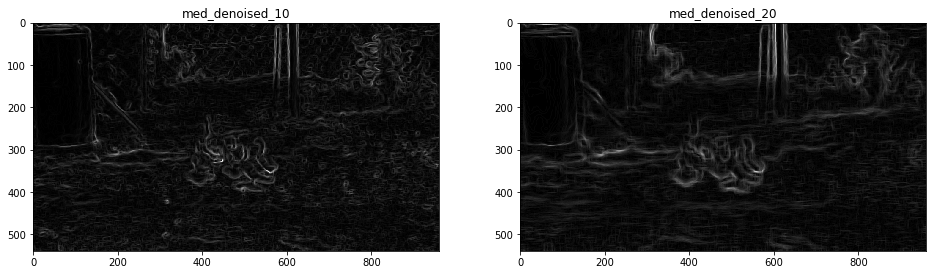

In [266]:
f, ([ax7, ax8]) = plt.subplots(1, 2, figsize=(16, 8))
ax7.imshow(imprewitt10, cmap='gray')
ax7.set_title("med_denoised_10")
ax8.imshow(imprewitt20, cmap='gray')
ax8.set_title("med_denoised_20")
plt.show()

### 3.3 Canny

In [305]:
Vmin = 100
Vmax = 200
imcanny = cv2.Canny(bn, Vmin, Vmax)
imcanny1 = cv2.Canny(bn1, Vmin, Vmax)
imcanny2 = cv2.Canny(bn2, Vmin, Vmax)
imcanny3 = cv2.Canny(bn3, Vmin, Vmax)
imcanny4 = cv2.Canny(bn4, Vmin, Vmax)
imcanny5 = cv2.Canny(bn5, Vmin, Vmax)
imcanny10 = cv2.Canny(bn10, Vmin, Vmax)
imcanny20 = cv2.Canny(bn20, Vmin, Vmax)

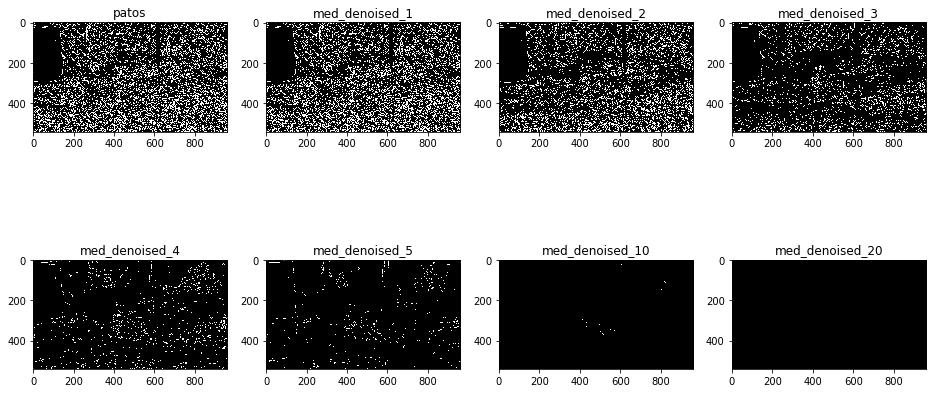

In [306]:
f, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]) = plt.subplots(2, 4, figsize=(16, 8))
ax1.imshow(imcanny, cmap='gray')
ax1.set_title("patos")
ax2.imshow(imcanny1, cmap='gray')
ax2.set_title("med_denoised_1")
ax3.imshow(imcanny2, cmap='gray')
ax3.set_title("med_denoised_2")
ax4.imshow(imcanny3, cmap='gray')
ax4.set_title("med_denoised_3")
ax5.imshow(imcanny4, cmap='gray')
ax5.set_title("med_denoised_4")
ax6.imshow(imcanny5, cmap='gray')
ax6.set_title("med_denoised_5")
ax7.imshow(imcanny10, cmap='gray')
ax7.set_title("med_denoised_10")
ax8.imshow(imcanny20, cmap='gray')
ax8.set_title("med_denoised_20")
plt.show()

**No se observan buenos resultados con Canny**

## 4. Binarización

### 4.1 Histograma Sobel

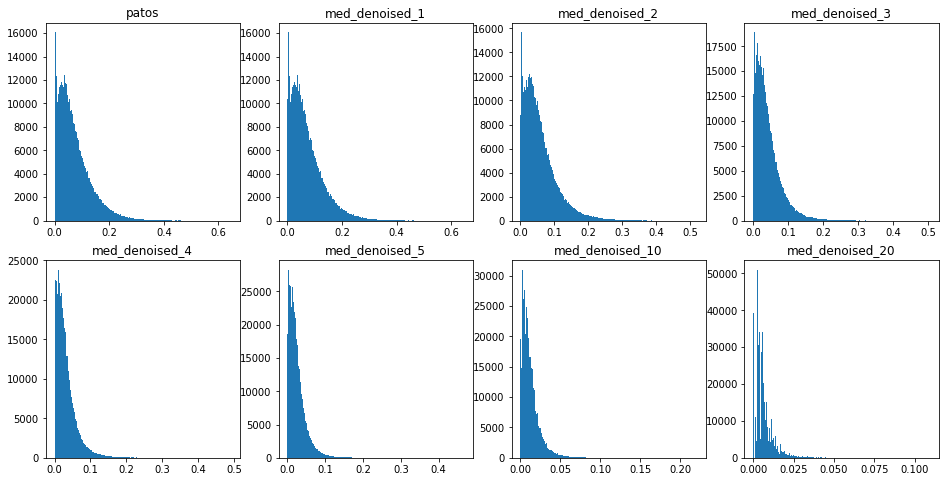

In [145]:
f, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]) = plt.subplots(2, 4, figsize=(16, 8))
ax1.hist(imsobel.ravel(), bins=256)
ax1.set_title("patos")
ax2.hist(imsobel1.ravel(), bins=256)
ax2.set_title("med_denoised_1")
ax3.hist(imsobel2.ravel(), bins=256)
ax3.set_title("med_denoised_2")
ax4.hist(imsobel3.ravel(), bins=256)
ax4.set_title("med_denoised_3")
ax5.hist(imsobel4.ravel(), bins=256)
ax5.set_title("med_denoised_4")
ax6.hist(imsobel5.ravel(), bins=256)
ax6.set_title("med_denoised_5")
ax7.hist(imsobel10.ravel(), bins=256)
ax7.set_title("med_denoised_10")
ax8.hist(imsobel20.ravel(), bins=256)
ax8.set_title("med_denoised_20")
plt.show()

### 4.2 Binarización Sobel

In [177]:
threshold = 0.03
binary_custom = imsobel > threshold
binary_custom1 = imsobel1 > threshold
binary_custom2 = imsobel2 > threshold
binary_custom3 = imsobel3 > threshold
binary_custom4 = imsobel4 > threshold
binary_custom5 = imsobel5 > threshold
binary_custom10 = imsobel10 > threshold
binary_custom20 = imsobel20 > threshold

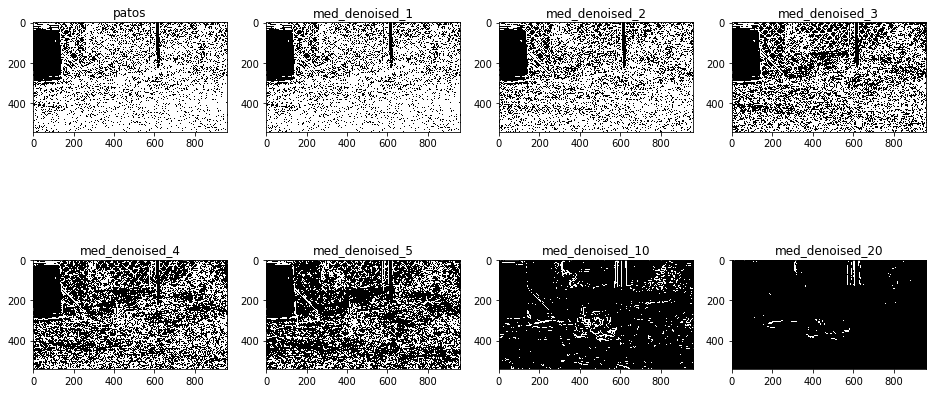

In [178]:
f, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]) = plt.subplots(2, 4, figsize=(16, 8))
ax1.imshow(binary_custom, cmap='gray')
ax1.set_title("patos")
ax2.imshow(binary_custom1, cmap='gray')
ax2.set_title("med_denoised_1")
ax3.imshow(binary_custom2, cmap='gray')
ax3.set_title("med_denoised_2")
ax4.imshow(binary_custom3, cmap='gray')
ax4.set_title("med_denoised_3")
ax5.imshow(binary_custom4, cmap='gray')
ax5.set_title("med_denoised_4")
ax6.imshow(binary_custom5, cmap='gray')
ax6.set_title("med_denoised_5")
ax7.imshow(binary_custom10, cmap='gray')
ax7.set_title("med_denoised_10")
ax8.imshow(binary_custom20, cmap='gray')
ax8.set_title("med_denoised_20")
plt.show()

**El mejor resultado de la Binarización Custom con Sobel es el del filtro de mediana de tamaño 10**

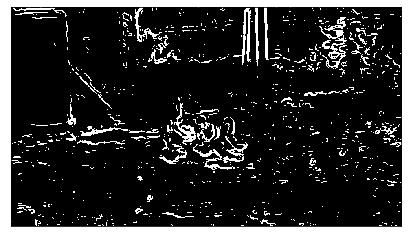

In [179]:
imshow(binary_custom10)

**Los mejores resultados con Binarización Otsu con Sobel son los del filtro de mediana de tamaño 5 y 10**

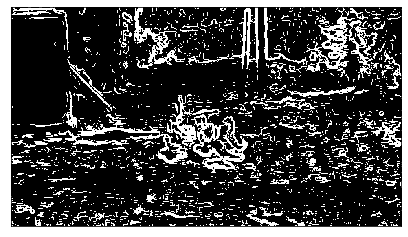

In [188]:
threshold_otsu10 = filters.threshold_otsu(imsobel10)
binary_otsu10 = imsobel10 > threshold_otsu10
imshow(binary_otsu10)

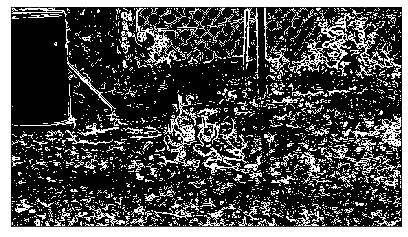

In [189]:
threshold_otsu5 = filters.threshold_otsu(imsobel5)
binary_otsu5 = imsobel5 > threshold_otsu5
imshow(binary_otsu5)

In [190]:
display(threshold_otsu10)
display(threshold_otsu5)

0.0202493106617647

0.03735205719320807

### 4.2 Histograma Prewitt

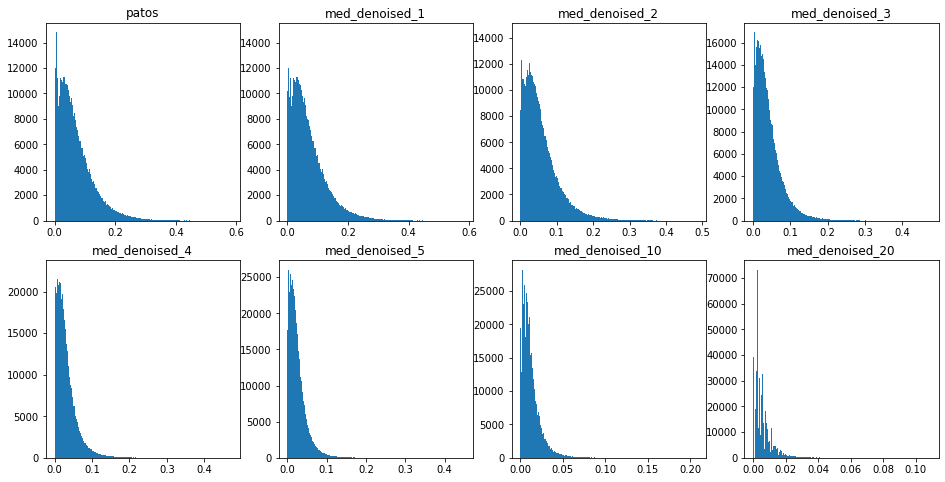

In [146]:
f, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]) = plt.subplots(2, 4, figsize=(16, 8))
ax1.hist(imprewitt.ravel(), bins=256)
ax1.set_title("patos")
ax2.hist(imprewitt1.ravel(), bins=256)
ax2.set_title("med_denoised_1")
ax3.hist(imprewitt2.ravel(), bins=256)
ax3.set_title("med_denoised_2")
ax4.hist(imprewitt3.ravel(), bins=256)
ax4.set_title("med_denoised_3")
ax5.hist(imprewitt4.ravel(), bins=256)
ax5.set_title("med_denoised_4")
ax6.hist(imprewitt5.ravel(), bins=256)
ax6.set_title("med_denoised_5")
ax7.hist(imprewitt10.ravel(), bins=256)
ax7.set_title("med_denoised_10")
ax8.hist(imprewitt20.ravel(), bins=256)
ax8.set_title("med_denoised_20")
plt.show()

### 4.4 Binarización Prewitt

In [191]:
threshold = 0.03
binary_customwitt = imprewitt > threshold
binary_customwitt1 = imprewitt1 > threshold
binary_customwitt2 = imprewitt2 > threshold
binary_customwitt3 = imprewitt3 > threshold
binary_customwitt4 = imprewitt4 > threshold
binary_customwitt5 = imprewitt5 > threshold
binary_customwitt10 = imprewitt10 > threshold
binary_customwitt20 = imprewitt20 > threshold

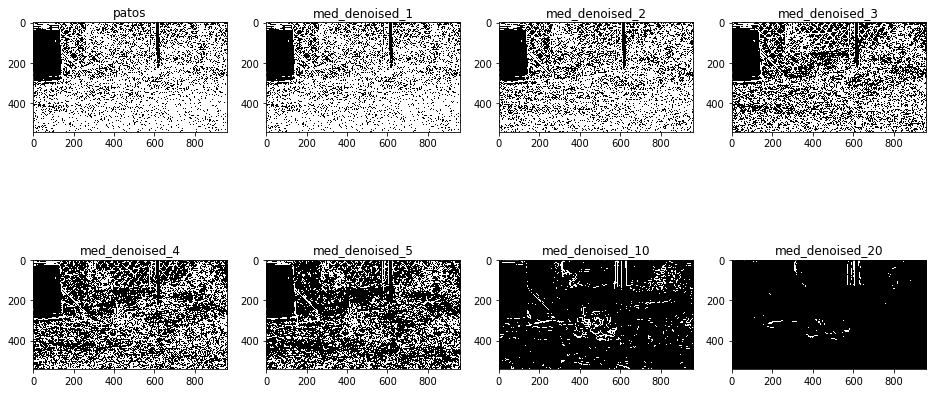

In [192]:
f, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]) = plt.subplots(2, 4, figsize=(16, 8))
ax1.imshow(binary_customwitt, cmap='gray')
ax1.set_title("patos")
ax2.imshow(binary_customwitt1, cmap='gray')
ax2.set_title("med_denoised_1")
ax3.imshow(binary_customwitt2, cmap='gray')
ax3.set_title("med_denoised_2")
ax4.imshow(binary_customwitt3, cmap='gray')
ax4.set_title("med_denoised_3")
ax5.imshow(binary_customwitt4, cmap='gray')
ax5.set_title("med_denoised_4")
ax6.imshow(binary_customwitt5, cmap='gray')
ax6.set_title("med_denoised_5")
ax7.imshow(binary_customwitt10, cmap='gray')
ax7.set_title("med_denoised_10")
ax8.imshow(binary_customwitt20, cmap='gray')
ax8.set_title("med_denoised_20")
plt.show()

**El mejor resultado de la Binarización Custom con Prewitt es el del filtro de mediana de tamaño 10**

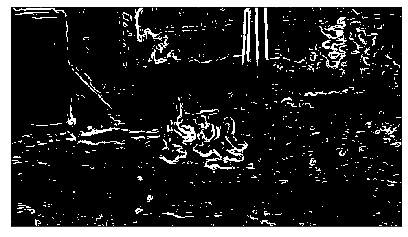

In [193]:
imshow(binary_customwitt10)

**Los mejores resultados con Binarización Otsu con Prewitt son los del filtro de mediana de tamaño 5 y 10**

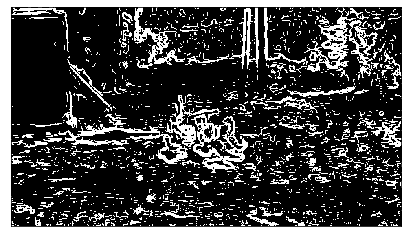

In [194]:
threshold_otsuwitt10 = filters.threshold_otsu(imprewitt10)
binary_otsuwitt10 = imprewitt10 > threshold_otsuwitt10
imshow(binary_otsuwitt10)

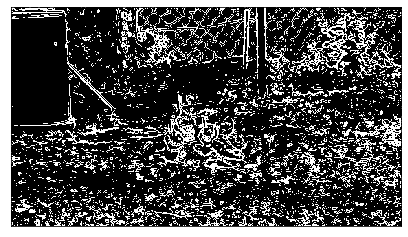

In [196]:
threshold_otsuwitt5 = filters.threshold_otsu(imprewitt5)
binary_otsuwitt5 = imprewitt5 > threshold_otsuwitt5
imshow(binary_otsuwitt5)

In [197]:
display(threshold_otsuwitt10)
display(threshold_otsuwitt5)

0.019847719118302083

0.03769788481920885

## 5. Operaciones morfológicas

### 5.1 Sobel

**Aplicamos dilatación y erosión al resultado de la Binarización Custom con Sobel y filtro de mediana de tamaño 10**

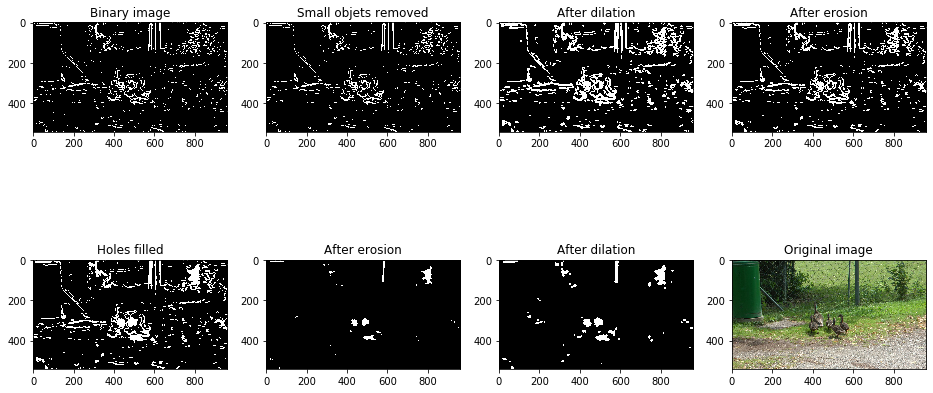

In [320]:
im0 = morphology.remove_small_objects(binary_custom10, 9)
im1 = morphology.dilation(image = im0, selem=disk(2))
im2 = morphology.erosion(image = im1, selem=disk(1))
im3 = ndi.binary_fill_holes(im2)
im4 = morphology.erosion(image = im3, selem=disk(5))
im5 = morphology.dilation(image = im4, selem=disk(4))


f, axes = plt.subplots(2,4, figsize=(16,8))
axes[0,0].imshow(binary_custom10, cmap='gray', aspect = 'equal')
axes[0,0].set_title('Binary image')
axes[0,1].imshow(im0, cmap='gray', aspect = 'equal')
axes[0,1].set_title('Small objets removed')
axes[0,2].imshow(im1, cmap='gray', aspect = 'equal')
axes[0,2].set_title('After dilation')
axes[0,3].imshow(im2, cmap='gray', aspect = 'equal')
axes[0,3].set_title('After erosion')
axes[1,0].imshow(im3, cmap='gray', aspect = 'equal')
axes[1,0].set_title('Holes filled')
axes[1,1].imshow(im4, cmap='gray', aspect = 'equal')
axes[1,1].set_title('After erosion')
axes[1,2].imshow(im5, cmap='gray', aspect = 'equal')
axes[1,2].set_title('After dilation')
axes[1,3].imshow(patos, cmap='gray', aspect = 'equal')
axes[1,3].set_title('Original image')
plt.show()

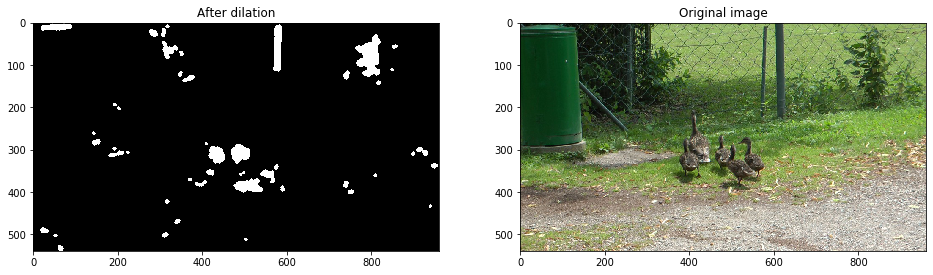

In [321]:
f, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].imshow(im5, cmap='gray', aspect = 'equal')
axes[0].set_title('After dilation')
axes[1].imshow(patos, cmap='gray', aspect = 'equal')
axes[1].set_title('Original image')
plt.show()

**El resultado no es satisfactorio**

**Ahora probamos aplicando dilatación y erosión al resultado de la Binarización Otsu con Sobel y filtro de mediana de tamaño 5**

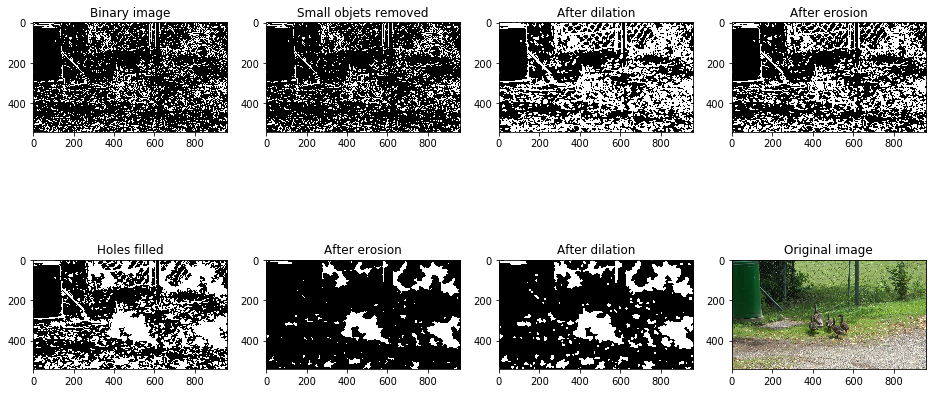

In [316]:
im0 = morphology.remove_small_objects(binary_otsu5, 9)
im1 = morphology.dilation(image = im0, selem=disk(2))
im2 = morphology.erosion(image = im1, selem=disk(1))
im3 = ndi.binary_fill_holes(im2)
im4 = morphology.erosion(image = im3, selem=disk(5))
im5 = morphology.dilation(image = im4, selem=disk(4))


f, axes = plt.subplots(2,4, figsize=(16,8))
axes[0,0].imshow(binary_otsu5, cmap='gray', aspect = 'equal')
axes[0,0].set_title('Binary image')
axes[0,1].imshow(im0, cmap='gray', aspect = 'equal')
axes[0,1].set_title('Small objets removed')
axes[0,2].imshow(im1, cmap='gray', aspect = 'equal')
axes[0,2].set_title('After dilation')
axes[0,3].imshow(im2, cmap='gray', aspect = 'equal')
axes[0,3].set_title('After erosion')
axes[1,0].imshow(im3, cmap='gray', aspect = 'equal')
axes[1,0].set_title('Holes filled')
axes[1,1].imshow(im4, cmap='gray', aspect = 'equal')
axes[1,1].set_title('After erosion')
axes[1,2].imshow(im5, cmap='gray', aspect = 'equal')
axes[1,2].set_title('After dilation')
axes[1,3].imshow(patos, cmap='gray', aspect = 'equal')
axes[1,3].set_title('Original image')
plt.show()

**El resultado de Binarización Otsu es aún peor que con Binarización Custom**

### 5.2 Prewitt

**Los resultados de Binarización Custom y Otsu con Prewitt son similares a los obtenidos con Sobel**

## 6. Slic

### 6.1 Sobel

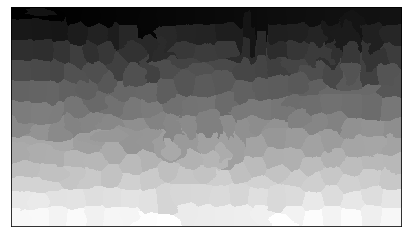

In [231]:
imshow(slic(med_denoised_20,n_segments=256))

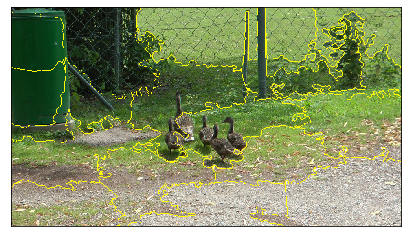

In [249]:
imshow(mark_boundaries(patos,slic(med_denoised_10,n_segments=20)))

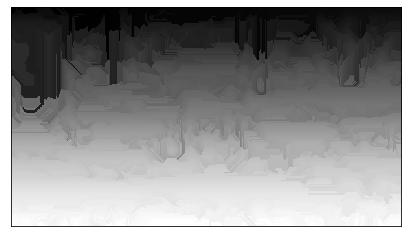

In [255]:
segmentationPatos = felzenszwalb(med_denoised_20,multichannel=True,sigma=10)
imshow(segmentationPatos)

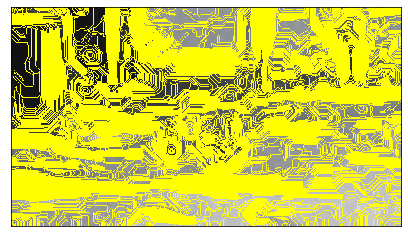

In [257]:
imshow(mark_boundaries(med_denoised_20,
                       segmentationPatos))

In [258]:
quickSegmentation = quickshift(patos,kernel_size=20, max_dist=5)

In [67]:
labels = segmentation.slic(patos, compactness=30, n_segments=400)
g = graph.rag_mean_color(patos, labels)

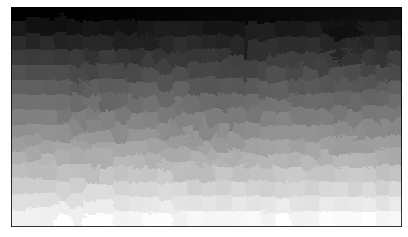

In [217]:
display(g)
imshow(labels)

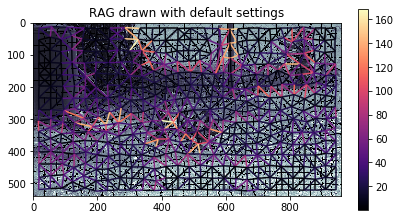

In [71]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 8))

ax.set_title('RAG drawn with default settings')
lc = graph.show_rag(labels, g, img, ax=ax)
# specify the fraction of the plot area that will be used to draw the colorbar
fig.colorbar(lc, fraction=0.03, ax=ax)

In [72]:
labels2 = graph.merge_hierarchical(labels, g, thresh=35, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

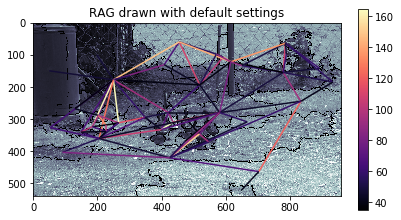

In [73]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 8))

ax.set_title('RAG drawn with default settings')
lc = graph.show_rag(labels, g, img, ax=ax)
# specify the fraction of the plot area that will be used to draw the colorbar
fig.colorbar(lc, fraction=0.03, ax=ax)

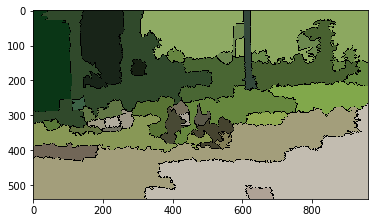

In [74]:
out = color.label2rgb(labels2, img, kind='avg')
out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))
plt.imshow(out)

# Resultado esperado

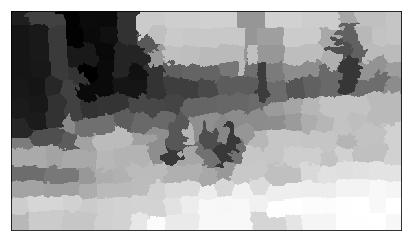

In [490]:
Resultado de la segmentacion

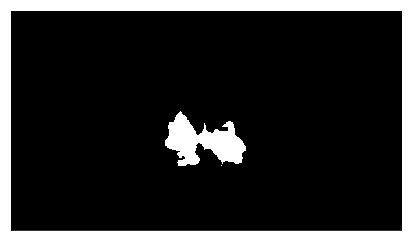

In [474]:
Resultado final